# Aprendizaje por refuerzo

In [1]:
from collections import defaultdict
import itertools

import numpy as np
import gym
from tqdm.notebook import tqdm

import train_utils

Qué hemos visto hasta ahora en aprendizaje máquina:

 * Aprendizaje **supervisado**: Las observaciones, $X$, tienen asociada una etiqueta, $y$, y el objetivo es encontrar un función $f: X \mapsto y$. Por ejemplo, clasificación y regresión.
 * Aprendizaje **no-supervisado**: Las observaciones , $X$, no tienen una etiqueta asociada y el objetivo es encontrar relaciones entre las observaciones. Por ejemplo, clustering y estimación de densidades.

Aprendizaje **reforzado**: 

* Un agente interactua con el entorno a través de acciones y obtiene una recompensa. 
* El objetivo es maximizar esa recompensa. 
* La recompensa no tiene por que ser inmediata, por lo que un agente puede realizar varias acciones antes de recibir una recompensa.

Ejemplos de aprendizaje reforzado:

* Juegos - El agente, jugador, trata de ganar (recompensa positiva) sin perder (recompensa negativa). P.ej, AlphaGo Zero. 
* Invertir en valores - Ganar dinero (positivo), perder (negativo)
* Planning - Elaborar una ruta. La ruta puede estar penalizada (negativa) por el número de pasos

Ejemplos de recompensas:

* Correr un maratón: El objetivo es llegar lo antes posible (penalización por tiempo). Alimentarse o hidratarse hace que tengamos una penalización a corto plazo, pero evitará que perdamos más tiempo a largo plazo.
* Jugar al tenis: Hacer un punto (recompensa positiva), que te hagan un punto (negativa).
* Estudiar para un examen: A corto plazo, estudiar puede tener una recompensa negativa porque no nos guste, pero a largo plazo aprobaremos el examen y no tendremos que estudiar (recompensa positiva)

¿Cómo el **agente** realiza la **interacción** con el **entorno**? La interacción se lleva a cabo en timesteps discretos, $ t = 0, 1, \ldots $. En cada iteración se realizan las siguientes tareas:

* El agente recibe una representación del estado actual del entorno, $s_t^a$,
* que tiene la información necesaria para realizar la acción, $a_t$, donde $a_t$ pertenece al conjunto de acciones disponibles en el estado $s_t$, $a_t \in A(s_t^a)$
* y obtiene una recompensa $r_t$ ($r \in \mathbb{R}$).

Representación gráfica de la interacción de un agente con el entorno.

<img src="images/reinforcement_learning_diagram.png" alt="rl diagram" width="300" class="center"/>

El estado del entorno, $s_t^e$, puede ser igual o contener más información que el estado que recibe el agente, $s_t^a$, dando lugar a dos tipos de entornos:
 * **Observable**: El agente es capaz de percibir toda la información del entorno, $s_t^a = s_t^e$. Por ejemplo, en el ajedrez el entorno es el tablero y la colocación de las piezas, en este caso un agente (jugador) es capaz de percibir todo el entorno.
 * **Parcialmente observable**: El agente es capaz de observar solo una parte del entorno $s_t^a \ne s_t^e$. Por ejemplo, en el juego flappy birds un agente (jugador) sólo percibe el entorno que se muestra en la pantalla, pero no tiene información sobre los obstaculos que hay después. 

La **historia** de un agente, $H_t$, es el secuencia de estados, acciones y recompensas hasta el instante $t$. $H_t = s_0, a_0, r_0, \ldots, s_t, a_t, r_t$.

**Objetivo**: máximizar la secuencia cumulativa de recompensas:

* Según la hipótesis de la recompensa (Rewards hypothesis), todos los objetivos pueden ser descritos como la maximización de la esperanza cumulativa de la recompensa. 
* En algunos casos es mejor sacrificar las recompensas a corto plazo para obtener una recompensa mayor a largo plazo.

## Markov decision process

* Un proceso de decision de Markov (MDP) proporciona un marco de trabajo matemático para sistemas de tomas de decisión donde hay aleatoriedad en las acciones tomadas. 
* Es un enfoque para algunos problemas de aprendizaje por refuerzo.

Un MDP está compuesto por los siguientes componentes:

* El estado, $S$,
* El conjunto de acciones, $A$, y las acciones disponibles para el estado $s$, $A(s)$,
* La probabilidad de transición $T(s,a,s\prime) \sim \mathbb{P}(s\prime|s,a)$, que es la probabilidad de acabar en el estado $s\prime$ al realizar la acción $a$ en el estado $s$,
* Y la recompensa $R(s,a,s\prime)$ que es la recompensa esperada al pasar de $s$ a $s\prime$ a través del la accción $a$.

Además, se tiene que cumplir la propiedad de Markov:

$\mathbb{P}(S_{t+1}|S_t) = \mathbb{P}(S_{t+1}|S_t, \ldots, S_0)$

que implica que el estado $s_t$ captura toda la información relevante de la historia (el **futuro** es independiente del **pasado** dado el **presente**).

**Objetivo**: Encontrar una policy $\pi$ que permita seleccionar la acción a tomar, $a_t$, en el estado $s_t$ ($\pi(s_t) = a_t$) que maximize una función de la secuencia cumulativa de recompensas.

Normalmente, esta función de la secuencia cumulativa de recompensas es la esperanza de la suma de recompensas descontada sobre un horizonte infinito:

$\mathbb{E}[\sum^\infty_{t=0} \gamma^t R(s_t,a_t,s_{t+1})]$

Donde $\gamma$ es el factor de descuento tal que $0 \le \gamma \le 1$.

El factor de descuento es un parámetro muy importante, que permite establecer cuan **lejos** el método tiene que mirar en el horizonte de recompensas:

* Un factor de descuento cercano a cero indica que solo las recompensas **inmediatas** son consideradas, 
* Un factor de descuento a uno permite considerar un **horizonte mayor**. 

¿Cuál es el mejor factor de descuento? Como en la mayoría de los parámetros en ML, esto dependerá del problema. En la práctica, en la mayoría de los casos se elige $\gamma = 0.9$.

**Definiciones**: 

La policy óptima, $\pi^*$, se representa como :

$\pi^* = argmax_\pi \mathbb{E} [\sum^\infty_{t=0} \gamma^t R(s_t) |\pi]$

Con esta información podemos definir la función Value, $V(s)$, que define la recompensa esperada en el futuro empezando desde el estado $s$ siguiendo la política $\pi$:

$V^\pi(s) = \mathbb{E}[\sum^\infty_{t=0} \gamma^t R(s_t) |\pi, s_0=s]$

y podemos escribir la política óptima en términos de $V(s)$:

$\pi^* = argmax_a \sum_{s\prime} T(s, a, s\prime) * V^{\pi^*} (s\prime)$

# Métodos para resolver problemas de aprendizaje reforzado

Para visualizar como funcionan los algoritmos que vamos a ver con un problema de aprendizaje reforzado llamado FrozenLake-v0:

<img src="images/frozen_lake.png" alt="frozen lake" width="300" class="center"/>

**Descripción del juego**: 
* caminar por un lago helado (F) para llegar a la meta (G), 
* evitando caerse al agua en las zonas donde la capa de hielo es menor (nos caeríamos) (H). 
* los nodos terminales, que indican que el juego se acaba, son G y H.
* Las acciones que puede realizar el agente son moverse a la izquierda, derecha, arriba y abajo. 
* El número de estados son 16, y representa cada una de las celdas del grid.

Fuente imagen: 
https://academy.dataiku.com/latest/tutorial/machine-learning/reinforcement-learning-q-learning.html

**Breve introduducción al paquete gym de Openai**

Lo primero que tenemos que hacer es crear un entorno (ver otros entornos en https://gym.openai.com/), y resetearlo para llevarlo al estado original:

In [2]:
env = gym.make('FrozenLake-v0', is_slippery=True)
env.reset()

0

Para visualizar el entorno utilizamos la función render. Esta función tiene un parámetro **mode** que nos permitirá utilizar diferentes tipos de representaciones como texto o gráfica, en el entorno frozenlake solo tenemos disponible la representación basada en texto

In [3]:
env.render()


SFFF
FHFH
FFFH
HFFG


El conjunto de posibles acciones se encuentra en el atributo **action_space**. En FrozenLake, solo disponemos de cuatro acciones: izquierda, abajo, derecha y arriba (0, 1, 2, 3) respectivamente.

In [4]:
env.action_space

Discrete(4)

El número de posibles estados se encuentra el atributo **nS**. En este problema son 16 (es un grid de 4x4)

In [5]:
env.nS

16

Para realizar una acción utilizamos el método **step**, que nos devuelve el nuevo estado, recompensa, un flag que nos indica si el juego ha terminado o no, e información sobre la transición

In [6]:
state, reward, done, info = env.step(2) 
print(state, reward, done)

4 0.0 False


In [7]:
info

{'prob': 0.3333333333333333}

Si visualizamos de nuevo el entorno veremos como el agente se ha movido de la celda inicial

In [8]:
env.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


Una vez terminado el entrenamiento podemos cerrar el entorno con el método **close**.

In [9]:
env.close()

## Programación dinámica

In [10]:
dp_params = {
    'discount_factor': {'values': np.arange(0, 1.1, 0.1), 'default': 1.0, 'text': 'discount_factor'}
}

### Value iteration

* Value iteration es un método para calcular la policy y funcion value óptima para un MDP,
* Este método parte de la premisa que la función value, $V(s)$, es suficiente para aprender la policy óptima. 
* Por lo tanto, este método primero cálcula $V(s)$, y posteriormente $\pi^*$. 

El método de value iteration utiliza la definición de $V(s) \equiv V^\pi(s)$, con las definiciones anteriores llegando a:

$V(s) = R(s) + \gamma max_a \sum_{s\prime} T(s, a, s\prime) V(s\prime)$

Con esta definición de $V(s)$, value iteration se define como:

$V_{t+1}(s) = R(s) + \gamma max_a \sum_{s\prime} T(s, a, s\prime) V_t(s\prime)$

donde se empieza con una función valor aleatoria, $V_0$, y se actualiza hasta que converja. En la práctica, el algoritmo se detiene cuando los cambios de la función valor son menores a un umbral, en este caso theta.

El psudo-código de value iteration es el siguiente (fuente http://incompleteideas.net/book/bookdraft2017nov5.pdf):

<img src="images/value_iteration.png" alt="value iteration" width="600" class="center"/>

In [11]:
def one_step_lookahead(env, state, V, discount_factor):
        """
        CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
        
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            A[a] = sum([prob * (reward + discount_factor * V[next_state]) 
                        for prob, next_state, reward, done in env.P[state][a]])
        return A

In [12]:
def value_iteration(env, theta=0.0001, discount_factor=1.0, return_history=True):
    """
    CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
    
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """

    V_history = []
    V = np.zeros(env.nS)
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(env, s, V, discount_factor)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value
        
        if return_history:
            V_history.append(V.copy())
            
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(env, s, V, discount_factor)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0

    if return_history:
        return policy, V, V_history
    else:
        return policy, V

**Demostración de value iteration en custom frozenlake**

In [13]:
plot_func = train_utils.multi_display(train_utils.display_lake_policy, None, train_utils.display_lake_value_history)
train_utils.display_learning_widget(value_iteration, dp_params, plot_func, env_params=train_utils.custom_env_params)

interactive(children=(SelectionSlider(continuous_update=False, description='discount_factor', index=10, option…

Ahora vamos a probar a jugar una partida

In [14]:
frozen_env = gym.make('custom-FrozenLake-v0', prob_action=0.8, rg_hole=0, rg_floor=0)
p_frozen, v_frozen = value_iteration(frozen_env, return_history=False, discount_factor=1)

In [15]:
train_utils.play_episode(frozen_env, p_frozen)

  (Down)
SFFF
FHFH
FFFH
HFFG


None

Rewards 1


In [16]:
train_utils.display_lake_policy(frozen_env, p_frozen)

↓,↑,↑,↑
←,H,↑,H
↑,↓,←,H
H,→,↓,G


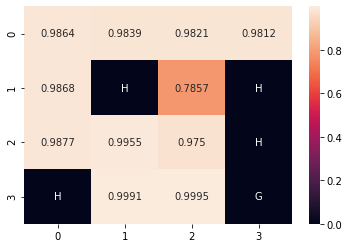

In [17]:
train_utils.display_lake_value(frozen_env, v_frozen)

### Policy iteration

Policy iteration es un método para calcular la política óptima para un MDP. El algoritmo está compuesto por dos métodos:

* policy evaluation: se calcula la función value (también llamada state-value) para una policy arbitraria.
* policy improvement: se mejora la policy utilizando la función value del paso anterior.

**Evaluation**:
 * Calculamos la función value utilizando una policy $\pi$ con las siguientes ecuaciones:

$V_\pi(s) = \mathbb{E}[G_t | S_t = s]$
$= \mathbb{E}[R_{t+1} + \gamma V_\pi(s_{t+1}) | S_t = s]$
$= \sum_{a} \pi(a|s) \sum_{s\prime, r} p(s, a, s\prime) * [r + \gamma V(s\prime)]$

**Improvement**:

* Una vez hemos calculado la función value $V_\pi(s)$ podemos utilizarla para mejorar la policy. 
* Para mejorar la política, se compara la acción seleccionada para un estado usando la política con la mejor acción utilizando la función valor, y en caso de ser diferentes, se actualiza la política.

El pseudo-código de policy iteration es el siguiente (fuente http://incompleteideas.net/book/bookdraft2017nov5.pdf):

<img src="images/policy_iteration.png" alt="policy iteration" width="600" class="center"/> 

In [18]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.001):
    """
    CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
    
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)


In [19]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
    
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(env, s, V, discount_factor)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V


**Demostración de policy iteration en custom frozenlake**

In [20]:
plot_func = train_utils.multi_display(train_utils.display_lake_policy, None, train_utils.display_lake_value_history)
train_utils.display_learning_widget(policy_improvement, dp_params, plot_func, env_params=train_utils.custom_env_params)

interactive(children=(SelectionSlider(continuous_update=False, description='discount_factor', index=10, option…

## Monte Carlo

* Los métodos vistos hasta ahora de programación dinámica tienen una gran limitación, ya que asumen que se tiene un conocimiento completo del entorno,
* En la práctica, esto no es siempre es así.
* Los métodos de monte carlo solucionan este problema aprendiendo del entorno a través de la experiencia generada al interaccionar con el entorno.
* Estos métodos tienen una gran varianza, pero no está sesgados. 
* Convergencia asintótica.

¿Cómo se definen la experiencia?

* La experiencia se agrupa en episodios (en el caso de los juegos, un episodio podría ser una partida),
* cada episodio esta compuesto de una secuencia ordenada de la 4-upla (estado, acción, recompensa y proximo estado)
* utilizando esta experiencia, podemos calcular la función state-action
* y mejorarla en cada episodio

¿Cómo estimamos la policy?

* Generamos una función state-action $Q(s,a)$ aleatoria,
* y creamos una policy $\pi$ utilizando $Q(s,a)$,
* Posteriormente, generamos un episodio siguiendo la policy $\pi$,
* Para cada estado y acción $s, a$ en el episodio, buscamos la primera vez que aparecen en el episodio,
* y calculamos la recompensa cumulativo desde ese punto,
* actualizamos $Q(s, a)$ con la media de todas las recompensas cumulativas para $s, a$.

Psuedo código del método montecarlo para estimar $\pi$ (fuente http://incompleteideas.net/book/bookdraft2017nov5.pdf):

<img src="images/montecarlo.png" alt="montecarlo" width="600" class="center"/> 

In [21]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [22]:
def mc_control_epsilon_greedy(env, num_episodes, episode_steps=100, discount_factor=1.0, epsilon=0.1, encode_state=None):
    """
    CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
    
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        encode_state: function to change the state representation
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm(range(1, num_episodes + 1)):
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(episode_steps):
            if encode_state:
                next_state = encode_state(next_state)
                
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(x[0], x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        # The policy is improved implicitly by changing the Q dictionary
    
    return dict(Q)

In [23]:
mc_params = {
    'discount_factor': {'values': np.arange(0, 1.1, 0.1), 'default': 1.0, 'text': 'discount_factor'},
    'epsilon': {'values': np.arange(0, 1.1, 0.1), 'default': 1.0, 'text': 'epsilon'},
    'num_episodes': {'values': (10**3, 10**4, 3 * 10**4, 6 * 10**4, 10**5, 10**6, 10**7), 'default': 10**4, 'text': 'num_episodes'},
}

**Demostración de Monte Carlo en frozenlake**

In [24]:
plot_func = train_utils.multi_plot(train_utils.display_lake_q, train_utils.display_lake_qpolicy)
train_utils.display_learning_widget(mc_control_epsilon_greedy, mc_params, plot_func, env_params=train_utils.custom_env_params)

interactive(children=(SelectionSlider(continuous_update=False, description='discount_factor', index=10, option…

## Temporal-difference Learning

* TD-Learning es una combinación de las técnicas Monte Carlo y programación dinámica,
* Como montecarlo, TD funciona con las experiencias y no requiere de un modelo del entorno
* Al igual que la programación dinámica, TD utiliza bootstrapping para hacer las actualizaciones.
* La convergencia de TD suele aprender más rápido pero están sesgados (a las condiciones iniciales),
* Por otra parte, los métodos basados en Monte Carlo no están sesgados pero requieren de más iteraciones para llegar a un resultado similar a TD.

<!-- 
The main problem with TD learning and DP is that their step updates are biased on the initial conditions of the learning parameters. The bootstrapping process typically updates a function or lookup Q(s,a) on a successor value Q(s',a') using whatever the current estimates are in the latter. Clearly at the very start of learning these estimates contain no information from any real rewards or state transitions.

If learning works as intended, then the bias will reduce asymptotically over multiple iterations. However, the bias can cause significant problems, especially for off-policy methods (e.g. Q Learning) and when using function approximators. That combination is so likely to fail to converge that it is called the deadly triad in Sutton & Bart.

Monte Carlo control methods do not suffer from this bias, as each update is made using a true sample of what Q(s,a) should be. However, Monte Carlo methods can suffer from high variance, which means more samples are required to achieve the same degree of learning compared to TD.

In practice, TD learning appears to learn more efficiently if the problems with the deadly triad can be overcome. Recent results using experience replay and staged "frozen" copies of estimators provide work-arounds that address problems - e.g. that is how DQN learner for Atari games was built. -->

Las actualizaciones en TD-Learning tienen normalmente la siguiente forma:
    
* $V(s_t) = V(s_t) + \alpha[R_{t+1} + \gamma V(s_{t+1}) - V(s_{t})]$,
* Estimacion = Valor actual + $\alpha$ [Nuevo valor - Valor actual],
* donde $0 \le \alpha \le 1$  es el parámetro de aprendizaje que regula las actualizaciones.
* El término $R_{t+1} + \gamma V(s_{t+1}) - V(s_{t})$ es el "error", de la estimación $V(s_{t})$ y la mejor estimación $R_{t+1} + \gamma V(s_{t+1})$.


En las siguientes secciones vamos a ver dos métodos basados en temporal-difference, que tienen la siguiente forma:

* El objetivo es calcular la función state-action ($Q(S, A)$)
* El método se repite para un cojunto de episodios predeterminado:
* Dentro del episodio, el método escoge una acción $a$ utilizando una policy derivada de $Q(S, A)$.
* Ejecuta la acción, obteniendo el nuevo estado $s\prime$, y la recompensa $r$,
* y actualizan $Q(S, A)$.
    

Las diferencias de los dos métodos radican en cómo se actualiza $Q(S, A)$:

* SARSA: Es un método on-policy. La actualización de los q-values se realiza utilizando la policy actual.
* Q-Learning: Es un método off-policy. La actualización de los q-values se realiza utilizando el siguiente estado $s\prime$ y la acción $a\prime$ utilizando un enfoque greedy.

In [25]:
td_params = {
    'discount_factor': {'values': np.arange(0, 1.1, 0.1), 'default': 1.0, 'text': 'discount_factor'},
    'alpha': {'values': np.arange(0, 1.1, 0.1), 'default': 0.5, 'text': 'alpha'},
    'epsilon': {'values': np.arange(0, 1.1, 0.1), 'default': 0.1, 'text': 'epsilon'},
    'num_episodes': {'values': (10**3, 10**4,  3 * 10**4, 6 * 10**4, 10**5, 10**6, 10**7), 'default': 10**4, 'text': 'num_episodes'},
}

### SARSA

* SARSA es un método on-policy, por lo que la función $Q(S,A)$ se actualiza utilizando la policy actual.
* En la actualización, el método elige una acción $a\prime$ para el estado $s\prime$ utilizando la policy derivada de $Q(S,A)$,
* y actualiza $Q(s,a) =  Q(s, a) + \alpha[R + \gamma Q(s\prime, a\prime) - Q(s, a)]$.
* Recordar que tiene una forma similar al "error" en TD.
* La acción $a\prime$ -> $a$, y $s\prime$ -> $s$, y pasamos a la siguiente iteración

Psuedo código del método SARSA (fuente http://incompleteideas.net/book/bookdraft2017nov5.pdf):

<img src="images/sarsa.png" alt="sarsa" width="600" class="center"/> 

### Q-Learning

* Q-Learning es un método off-policy, por lo que la función $Q(S,A)$ se actualiza utilizando un enfoque greedy.
* En la actualización, el método elige una acción $a\prime$ para el estado $s\prime$ utilizando un enfoque greedy,
* y actualiza $Q(s,a) =  Q(s, a) + \alpha[R + \gamma max_{a\prime} Q(s\prime, a\prime) - Q(s, a)]$.
* Recordar que tiene una forma similar al "error" en TD.
* El estado $s\prime$ -> $s$, y pasamos a la siguiente iteración


Psuedo código del método q learning (fuente http://incompleteideas.net/book/bookdraft2017nov5.pdf):

<img src="images/qlearning.png" alt="q learning" width="600" class="center"/> 

### Implementaciones de SARSA y Q-Learning

In [26]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, encode_state=None):
    """
    CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
    
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        encode_state: function to change the state representation
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm(range(num_episodes)):
        
        # Reset the environment and pick the first action
        state = env.reset()
        if encode_state:
            state = encode_state(state)
            
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            if encode_state:
                next_state = encode_state(next_state)
            
            # Pick the next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state        

    return dict(Q)

**Demostración de sarsa en frozenlake**

In [27]:
plot_func = train_utils.multi_plot(train_utils.display_lake_q, train_utils.display_lake_qpolicy)
train_utils.display_learning_widget(sarsa, 
                                    td_params, 
                                    plot_func, 
                                    env_params=train_utils.custom_env_params)

interactive(children=(SelectionSlider(continuous_update=False, description='discount_factor', index=10, option…

In [28]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, encode_state=None):
    """
    CODE FROM (code might be modified): https://github.com/dennybritz/reinforcement-learning
    
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
        encode_state: function to change the state representation
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) 
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm(range(num_episodes)):
        # Reset the environment and pick the first action
        state = env.reset()

        if encode_state:
            state = encode_state(state)
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():        
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            if encode_state:
                next_state = encode_state(next_state)
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                 
            if done:
                break
                
            state = next_state   
    return dict(Q)

**Demostración de Q-Learning en frozenlake**

In [29]:
plot_func = train_utils.multi_plot(train_utils.display_lake_q, train_utils.display_lake_qpolicy)
train_utils.display_learning_widget(q_learning, td_params, plot_func, env_params=train_utils.custom_env_params)

interactive(children=(SelectionSlider(continuous_update=False, description='discount_factor', index=10, option…

## Otros entornos de gym para prácticar

### Taxi env

**Description**:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
    
**Observations**: 
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 
    
**Passenger locations**:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi
    
**Destinations**:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
        
**Actions**:
There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger
- 5: dropoff passenger
    
**Rewards**: 
There is a reward of -1 for each action and an additional reward of +20 for delivering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.
    

In [30]:
taxi_env = gym.make('Taxi-v3')

In [31]:
taxi_env.render()
taxi_env.close()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Podéis utilizar la función cached_call que persite las ejecuciones entre sesiones para probar diferentes combinaciones, tiene como parámetros la función que vais utilizar para resolver el problema, el nombre del entorno, un diccionario con los argumentos para crear el entorno, y otro diccionario con los parámetros del método. El resultado es una tupla con el resultado/s del método, y el entorno

In [32]:
Q_mc, taxi_env = train_utils.cached_call(q_learning, 'Taxi-v3', {}, method_kwargs={'num_episodes':10**4})

También podéis utilizar la función directamente

In [33]:
# Q_mc = q_learning(taxi_env, num_episodes=10**4)

Para reproducir un episodio podéis utilizar la función play_episode, que recibe como parámetro el entorno y una policy

In [34]:
train_utils.play_episode(taxi_env, train_utils.get_policy_from_q(Q_mc, taxi_env.nS, taxi_env.action_space.n))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


None

Rewards 20


### MountainCar 

Ver descripción del entorno en https://gym.openai.com/envs/MountainCar-v0/ y https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

In [35]:
car_env = gym.make('MountainCar-v0')
car_env.reset()
car_env.render()

True

In [36]:
car_env.close()

In [37]:
class MountainCairStateEncoder:
    
    def __init__(self, env, num_buckets_v = 20, num_buckets_x = 20):
        self.env = env
        self.num_buckets_v = num_buckets_v
        self.num_buckets_x = num_buckets_x
        
        self.min_x = env.unwrapped.min_position
        self.max_x = env.unwrapped.max_position
        
        self.min_v = -env.unwrapped.max_speed
        self.max_v = env.unwrapped.max_speed
    
        self.nS = self.num_buckets_v * self.num_buckets_x
        
    def get_bucket(self, vmin, vmax, v, num_buckets):
        bucket_size = (vmax - vmin) / num_buckets
        return int((v - vmin) // bucket_size)
        
    def __call__(self, state):
        x, v = state
        bucket_x = self.get_bucket(self.min_x, self.max_x, x, self.num_buckets_x)
        bucket_v = self.get_bucket(self.min_v, self.max_v, v, self.num_buckets_v)
        return int(bucket_x * self.num_buckets_v + bucket_v)
    
    def __hash__(self):
        return hash((self.num_buckets_v, self.num_buckets_x))

In [38]:
car_state_encoder = MountainCairStateEncoder(car_env)
Q_car, car_env = train_utils.cached_call(q_learning, 'MountainCar-v0', {}, {'num_episodes': 3 * 10**3, 'encode_state':car_state_encoder})
p_car = train_utils.get_policy_from_q(Q_car, car_state_encoder.nS, car_env.action_space.n)

In [39]:
train_utils.play_episode(car_env, p_car, encode_state=car_state_encoder, max_steps=2500)
car_env.close()

True

Rewards -1.0


## CartPole-v1

Descripción del entorno en https://gym.openai.com/envs/CartPole-v1/ y https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

# Referencias:

* Libro de Sutton & Barto, no es muy complejo y está abierto en: http://incompleteideas.net/book/bookdraft2017nov5.pdf
* Diapositivas de Silver: https://www.davidsilver.uk/teaching/